# Lekce 17: Úvod do lineárního programování

Nejdříve načtěme nutné balíčky.

In [1]:
using Convex
using SCS
using Plots
using Random
using LinearAlgebra

Random.seed!(1);

Podobně jako v hodině na nejmenší čtverce, zadefinujme skutečnou predikční funkci $h_{\rm true}$, a nagenerujme data $(x_i,y_i)$. Všimněme si, že do dat přidáváme náhodný šum.

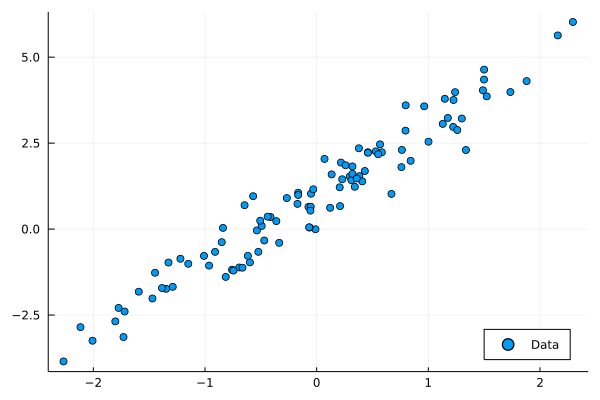

In [2]:
h_true(x::Real) = 2*x + 1

n = 100
xs = randn(n)

X = hcat(xs, ones(n))
y = h_true.(xs) + 0.5*randn(n)

scatter(xs, y; label="Data", legend=:bottomright)

Regresní problém má tvar $$\text{minimalizuj}\qquad \|Xw - y\|_p,$$ kde $p\in\{1,2,\infty\}$ určuje jakou normou budeme uvažovat. Napišme funkci `regression`, která najde řešení $w$ pro zadané $X$, $y$ a $p$.

In [3]:
function regression(X, y, p; kwargs...)
    n, m = size(X)

    w = Variable(m)
    if p==1 || p==2
        loss = sum(norm(X*w - y, p)) / n
    elseif p==Inf
        loss = sum(norm(X*w - y, p))
    end
    problem = minimize(loss)

    solve!(problem, () -> SCS.Optimizer(; kwargs...))
    return evaluate(w)
end;

Pro $p=1$ a $p=\infty$ můžeme regresi přeformulovat jako čistě lineární problém.

In [4]:
function regression_reformulation(X, y, p; kwargs...)
    n, m = size(X)

    w = Variable(m)
    if p==1
        z = Variable(n)

        constraints = [z >= 0]
        constraints += [X*w - y <= z]
        constraints += [X*w - y >= -z]

        loss = sum(z) / n
    elseif p==Inf
        z = Variable(1)

        constraints = [z >= 0]
        constraints += [X*w - y <= z]
        constraints += [X*w - y >= -z]

        loss = z
    end
    problem = minimize(loss, constraints)

    solve!(problem, () -> SCS.Optimizer(; kwargs...))
    return evaluate(w)
end;

Vidíme, že pro $p=1$ dávají oba přístupy stejný výsledek.

In [5]:
w1 = regression(X, y, 1; verbose=0)
w2 = regression_reformulation(X, y, 1; verbose=0)

norm(w1 - w2)

6.691673534153456e-6

Stejně tak i pro $p=\infty$.

In [6]:
w1 = regression(X, y, Inf; verbose=0)
w2 = regression_reformulation(X, y, Inf; verbose=0)

norm(w1 - w2)

1.538133245922693e-5

Když se nyní podíváme na průběh optimalizace, tak vidíme, že optimalizace skončila za 40 iterací. Algoritmus trackuje nejrůznější věci jako jsou primární a duální rezidua, duality gap či hodnota účelové funkce.

In [7]:
regression(X, y, 1; verbose=1);

----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 701, CG tol ~ 1/iter^(2.00)
eps = 1.00e-005, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-003
Variables n = 103, constraints m = 201
Cones:	primal zero / dual free vars: 1
	linear vars: 200
Setup time: 1.08e-004s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|9.15e+019 5.46e+019 1.00e+000 -1.94e+021 1.16e+020 8.95e+020 4.22e-005 
    40|8.04e-007 7.53e-007 5.57e-007 4.12e-001 4.12e-001 4.27e-016 9.85e-004 
---------------------------------------------------------------

Pusťme optimalizaci pro všechny tři normy.

In [8]:
w1 = regression(X, y, 1; verbose=0)
w2 = regression(X, y, 2; verbose=0)
w3 = regression(X, y, Inf; verbose=0);

Zadefinujme predikční funkci a vykresleme všechny predikce. Vidíme, že jsou blízko skutečné závislosti.

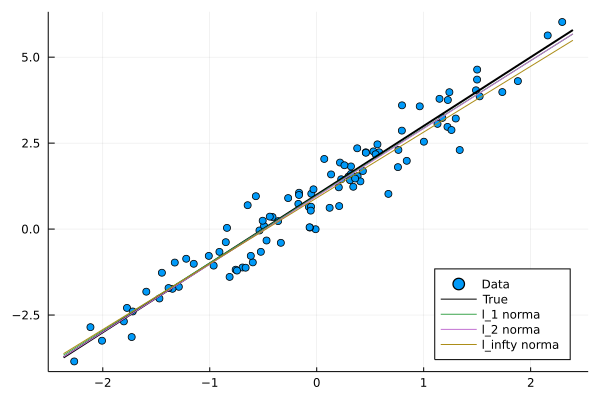

In [9]:
f_pred(x::Real, w) = w[1]*x + w[2];

xlims = extrema(xs) .+ [-0.1; 0.1]

scatter(xs, y; label="Data", legend=:bottomright)
plot!(xlims, h_true; label="True", line=(:black,2))
plot!(xlims, x -> f_pred(x, w1); label="l_1 norma")
plot!(xlims, x -> f_pred(x, w2); label="l_2 norma")
plot!(xlims, x -> f_pred(x, w3); label="l_infty norma")

Přidejme nyní jednoho outliera.

In [10]:
X_ext = [X; -2 1]
y_ext = [y; 10];

Pusťme znovu regresi a vykresleme stejný graf. Vidíme, že $l_1$ řešení je nejstabilnější, $l_2$ dává pořád dobré řešení, ale $l_\infty$ je zcela mimo.

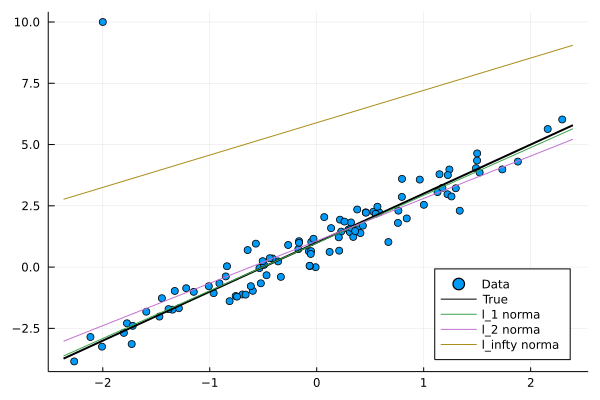

In [11]:
w1 = regression(X_ext, y_ext, 1; verbose=0)
w2 = regression(X_ext, y_ext, 2; verbose=0)
w3 = regression(X_ext, y_ext, Inf; verbose=0)

scatter(X_ext[:,1], y_ext; label="Data", legend=:bottomright)
plot!(xlims, h_true; label="True", line=(:black,2))
plot!(xlims, x -> f_pred(x, w1); label="l_1 norma")
plot!(xlims, x -> f_pred(x, w2); label="l_2 norma")
plot!(xlims, x -> f_pred(x, w3); label="l_infty norma")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*